## **Notebook PC#07**
## Self-Organizing Map (SOM) for the Travelling Salesperson Problem (TSP)<BR>
Code based on [this content](https://github.com/diego-vicente/som-tsp). <BR>

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Beatriz Akiria de Assis Quaresma - 203899 <br>
**Aluno(a):** Decio Miranda Filho - 236087

In [ ]:
# plot.py
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_network(cities, neurons, name='diagram.png', ax=None):
    """Plot a graphical representation of the problem"""
    mpl.rcParams['agg.path.chunksize'] = 10000

    if not ax:
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(cities['x'], cities['y'], color='red', s=4)
        axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)

        plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=200)
        plt.close()

    else:
        ax.scatter(cities['x'], cities['y'], color='red', s=4)
        ax.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)
        return ax

def plot_route(cities, route, name='diagram.png', ax=None):
    """Plot a graphical representation of the route obtained"""
    mpl.rcParams['agg.path.chunksize'] = 10000

    if not ax:
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(cities['x'], cities['y'], color='red', s=4)
        route = cities.reindex(route)
        route.loc[route.shape[0]] = route.iloc[0]
        axis.plot(route['x'], route['y'], color='purple', linewidth=1)

        plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=200)
        plt.close()

    else:
        ax.scatter(cities['x'], cities['y'], color='red', s=4)
        route = cities.reindex(route)
        route.loc[route.shape[0]] = route.iloc[0]
        ax.plot(route['x'], route['y'], color='purple', linewidth=1)
        return ax

In [ ]:
# neuron.py
import numpy as np

def generate_network(size):
    """
    Generate a neuron network of a given size.

    Return a vector of two dimensional points in the interval [0,1].
    """
    return np.random.rand(size, 2)

def get_neighborhood(center, radix, domain):
    """Get the range gaussian of given radix around a center index."""

    # Impose an upper bound on the radix to prevent NaN and blocks
    if radix < 1:
        radix = 1

    # Compute the circular network distance to the center
    deltas = np.absolute(center - np.arange(domain))
    distances = np.minimum(deltas, domain - deltas)

    # Compute Gaussian distribution around the given center
    return np.exp(-(distances*distances) / (2*(radix*radix)))

def get_route(cities, network):
    """Return the route computed by a network."""
    cities['winner'] = cities[['x', 'y']].apply(
        lambda c: select_closest(network, c),
        axis=1, raw=True)

    return cities.sort_values('winner').index

In [ ]:
# io_helper.py
import pandas as pd

def read_tsp(filename):
    """
    Read a file in .tsp format into a pandas DataFrame

    The .tsp files can be found in the TSPLIB project. Currently, the library
    only considers the possibility of a 2D map.
    """
    with open(filename) as f:
        node_coord_start = None
        dimension = None
        lines = f.readlines()

        # Obtain the information about the .tsp
        i = 0
        while not dimension or not node_coord_start:
            line = lines[i]
            if line.startswith('DIMENSION :'):
                dimension = int(line.split()[-1])
            elif line.startswith('DIMENSION:'):
                dimension = int(line.split()[-1])
            if line.startswith('NODE_COORD_SECTION'):
                node_coord_start = i
            i = i+1

        print('Problem with {} cities read.'.format(dimension))

        f.seek(0)

        # Read a data frame out of the file descriptor
        cities = pd.read_csv(
            f,
            skiprows=node_coord_start + 1,
            sep=' ',
            names=['city', 'y', 'x'],
            dtype={'city': str, 'x': np.float64, 'y': np.float64},
            header=None,
            nrows=dimension,
            skipinitialspace=True
        )

        # cities.set_index('city', inplace=True)

        return cities

def normalize(points):
    """
    Return the normalized version of a given vector of points.

    For a given array of n-dimensions, normalize each dimension by removing the
    initial offset and normalizing the points in a proportional interval: [0,1]
    on y, maintining the original ratio on x.
    """
    ratio = (points.x.max() - points.x.min()) / (points.y.max() - points.y.min()), 1
    ratio = np.array(ratio) / max(ratio)
    norm = points.apply(lambda c: (c - c.min()) / (c.max() - c.min()))
    return norm.apply(lambda p: ratio * p, axis=1)

In [ ]:
# distance.py

def select_closest(candidates, origin):
    """Return the index of the closest candidate to a given point."""
    return euclidean_distance(candidates, origin).argmin()

def euclidean_distance(a, b):
    """Return the array of distances of two numpy arrays of points."""
    return np.linalg.norm(a - b, axis=1)

def route_distance(cities):
    """Return the cost of traversing a route of cities in a certain order."""
    points = cities[['x', 'y']]
    distances = euclidean_distance(points, np.roll(points, 1, axis=0))
    return np.sum(distances)

In [ ]:
# main.py

def main():

    problem = read_tsp('qa194.tsp')

    route = som(problem, 100000)

    problem = problem.reindex(route)

    distance = route_distance(problem)

    print('Route found of length {}'.format(distance))


def som(problem, iterations, learning_rate=0.8):
    """Solve the TSP using a Self-Organizing Map."""

    # Obtain the normalized set of cities (w/ coord in [0,1])
    cities = problem.copy()

    cities[['x', 'y']] = normalize(cities[['x', 'y']])

    # The population size is 8 times the number of cities
    n = cities.shape[0] * 8

    # Generate an adequate network of neurons:
    network = generate_network(n)
    print('Network of {} neurons created. Starting the iterations:'.format(n))

    for i in range(iterations):
        if not i % 100:
            print('\t> Iteration {}/{}'.format(i, iterations), end="\r")
        # Choose a random city
        city = cities.sample(1)[['x', 'y']].values
        winner_idx = select_closest(network, city)
        # Generate a filter that applies changes to the winner's gaussian
        gaussian = get_neighborhood(winner_idx, n//10, network.shape[0])
        # Update the network's weights (closer to the city)
        network += gaussian[:,np.newaxis] * learning_rate * (city - network)
        # Decay the variables
        learning_rate = learning_rate * 0.99997
        n = n * 0.9997

        # Check for plotting interval
        if not i % 2000:
          if i > 0:
            plot_network(cities, network, name='{:05d}.png'.format(i))

        # Check if any parameter has completely decayed.
        if n < 1:
            print('Radius has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
        if learning_rate < 0.001:
            print('Learning rate has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
    else:
        print('Completed {} iterations.'.format(iterations))

    plot_network(cities, network, name='final.png')

    route = get_route(cities, network)
    plot_route(cities, route, 'route.png')
    return route

if __name__ == '__main__':
    main()

Problem with 194 cities read.
Network of 1552 neurons created. Starting the iterations:


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Radius has completely decayed, finishing execution at 24487 iterations


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Route found of length 9853.026507777486


In [ ]:
problem = read_tsp('qa194.tsp')
with pd.option_context('display.max_rows', None,):
    print(problem)

Problem with 194 cities read.
    city           y           x
0      1  24748.3333  50840.0000
1      2  24758.8889  51211.9444
2      3  24827.2222  51394.7222
3      4  24904.4444  51175.0000
4      5  24996.1111  51548.8889
5      6  25010.0000  51039.4444
6      7  25030.8333  51275.2778
7      8  25067.7778  51077.5000
8      9  25100.0000  51516.6667
9     10  25103.3333  51521.6667
10    11  25121.9444  51218.3333
11    12  25150.8333  51537.7778
12    13  25158.3333  51163.6111
13    14  25162.2222  51220.8333
14    15  25167.7778  51606.9444
15    16  25168.8889  51086.3889
16    17  25173.8889  51269.4444
17    18  25210.8333  51394.1667
18    19  25211.3889  51619.1667
19    20  25214.1667  50807.2222
20    21  25214.4444  51378.8889
21    22  25223.3333  51451.6667
22    23  25224.1667  51174.4444
23    24  25233.3333  51333.3333
24    25  25234.1667  51203.0556
25    26  25235.5556  51330.0000
26    27  25235.5556  51495.5556
27    28  25242.7778  51428.8889
28    29  252

In [ ]:
# Code based on: https://stackoverflow.com/questions/41228209/making-gif-from-images-using-imageio-in-python
import os
import imageio

png_dir = '.'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('movie.gif', images)

<ipython-input-58-a7086ab0b9b2>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
<ipython-input-58-a7086ab0b9b2>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


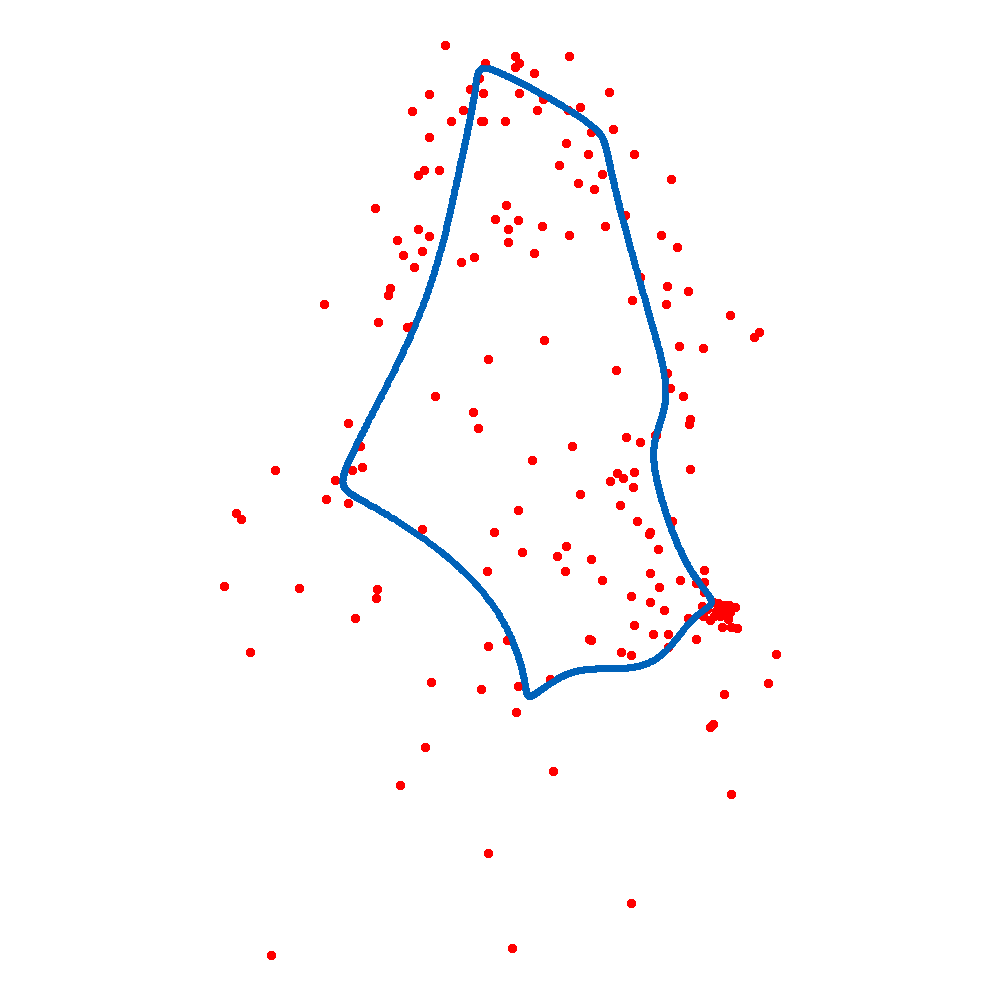

In [ ]:
from IPython.display import Image

Image('movie.gif', width=500, height=500)

Instruções para a atividade seguinte: Após concluir a execução das células anteriores, escolha alguma nova instância de TSP disponível
[aqui](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/), carregue o respectivo arquivo no ambiente Colab, apague os atuais arquivos [*.png] com o comando a seguir e execute as células na sequência, incluindo o nome do arquivo que você escolheu no local devido, o qual contém as coordenadas das cidades.

In [ ]:
!rm *.png

In [ ]:
# main2.py

def main():

    problem2 = read_tsp('vm1084.tsp') # Please, insert here the new filename.

    route2 = som(problem2, 100000)

    problem2 = problem2.reindex(route2)

    distance2 = route_distance(problem2)

    print('Route found of length {}'.format(distance2))


def som(problem, iterations, learning_rate=0.8):
    """Solve the TSP using a Self-Organizing Map."""

    # Obtain the normalized set of cities (w/ coord in [0,1])
    cities = problem.copy()

    cities[['x', 'y']] = normalize(cities[['x', 'y']])

    # The population size is 8 times the number of cities
    n = cities.shape[0] * 8

    # Generate an adequate network of neurons:
    network = generate_network(n)
    print('Network of {} neurons created. Starting the iterations:'.format(n))

    for i in range(iterations):
        if not i % 100:
            print('\t> Iteration {}/{}'.format(i, iterations), end="\r")
        # Choose a random city
        city = cities.sample(1)[['x', 'y']].values
        winner_idx = select_closest(network, city)
        # Generate a filter that applies changes to the winner's gaussian
        gaussian = get_neighborhood(winner_idx, n//10, network.shape[0])
        # Update the network's weights (closer to the city)
        network += gaussian[:,np.newaxis] * learning_rate * (city - network)
        # Decay the variables
        learning_rate = learning_rate * 0.99997
        n = n * 0.9997

        # Check for plotting interval
        if not i % 2000:
          if i > 0:
            plot_network(cities, network, name='{:05d}.png'.format(i))

        # Check if any parameter has completely decayed.
        if n < 1:
            print('Radius has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
        if learning_rate < 0.001:
            print('Learning rate has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
    else:
        print('Completed {} iterations.'.format(iterations))

    plot_network(cities, network, name='final.png')

    route = get_route(cities, network)
    plot_route(cities, route, 'route.png')
    return route

if __name__ == '__main__':
    main()

Problem with 1084 cities read.
Network of 8672 neurons created. Starting the iterations:


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Radius has completely decayed, finishing execution at 30221 iterations


<ipython-input-52-a8be14d29800>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)


Route found of length 264689.8398389389


In [ ]:
problem2 = read_tsp('vm1084.tsp') # Please, insert here the new filename.
with pd.option_context('display.max_rows', None,):
    print(problem2)

Problem with 1084 cities read.
      city        y        x
0        1   4080.0   5236.0
1        2   4688.0   6468.0
2        3   5296.0   9218.0
3        4   9392.0  10956.0
4        5   9536.0   9944.0
5        6   9680.0   7106.0
6        7   9936.0   9108.0
7        8  10240.0   6248.0
8        9  10544.0   5258.0
9       10  15504.0   6050.0
10      11  15552.0   8096.0
11      12  15600.0  10032.0
12      13  18864.0  11649.0
13      14  18895.5  11330.0
14      15  18928.0   7491.0
15      16  18928.0  11154.0
16      17  12496.0   9548.0
17      18  12528.0   7128.0
18      19  12560.0   5698.0
19      20   8880.0   8888.0
20      21   9984.0   5808.0
21      22  11088.0   5038.0
22      23  11952.0   5368.0
23      24  11968.0   6468.0
24      25  11984.0   9218.0
25      26  12368.0   9218.0
26      27  12432.0   6468.0
27      28  12496.0   5368.0
28      29  13264.0   9328.0
29      30  13312.0   6688.0
30      31  13360.0   5478.0
31      32    560.0   4532.0
32      33  

In [ ]:
# Code based on: https://stackoverflow.com/questions/41228209/making-gif-from-images-using-imageio-in-python
import os
import imageio

png_dir = '.'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('movie2.gif', images)

<ipython-input-63-52db64c8304d>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
<ipython-input-63-52db64c8304d>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


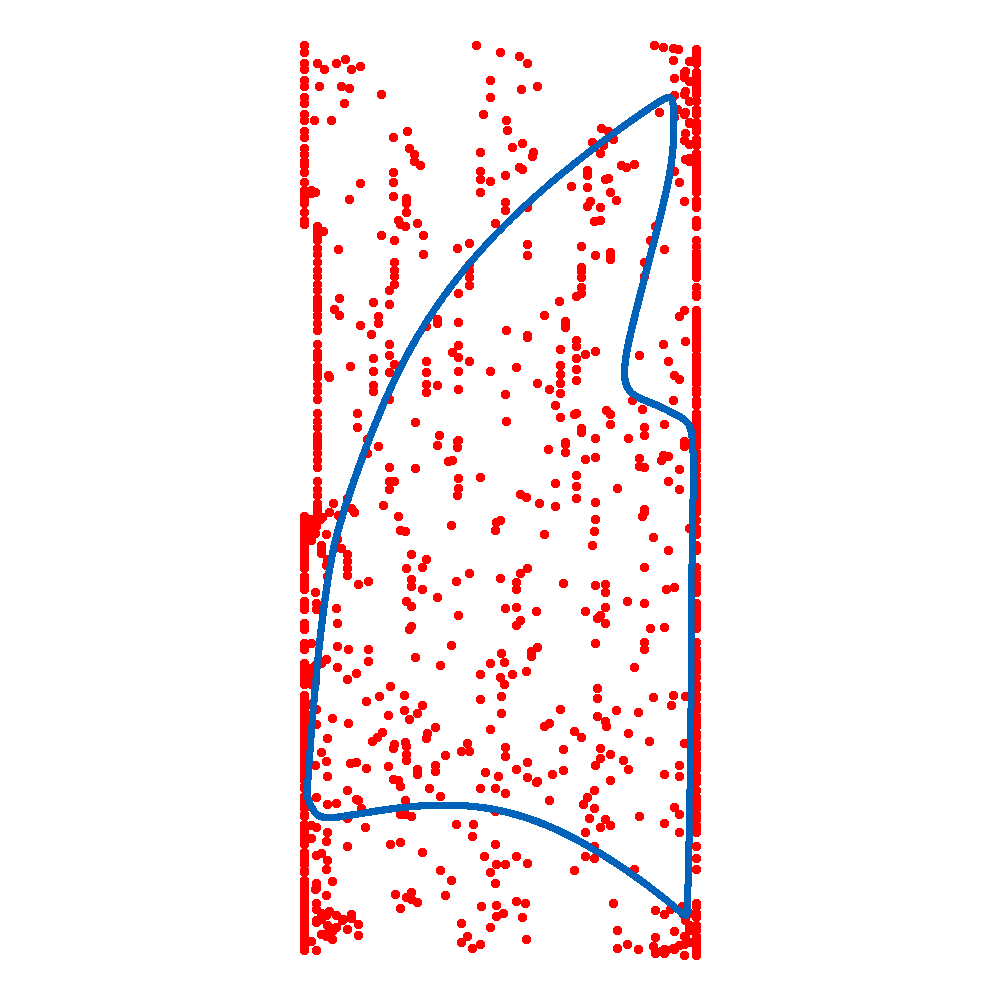

In [ ]:
Image('movie2.gif', width=500, height=500)

# **`ATIVIDADES`**


<font color="green">
Atividade (a) <br>
A solução adota um mapa auto-organizável unidimensional. Repare que a
proposta difere daquela apresentada em aula. Na proposta apresentada em aula, há
inserção e remoção de neurônios ao longo do processo de auto-organização, o que
não ocorre aqui. Descreva o princípio de operação da técnica, que opera como
“um anel elástico que vai se expandindo e aderindo às coordenadas das cidades”.
Para tanto, consulte o material em: [ https://diego.codes/post/som-tsp/ ]. <br>
</font>


**Resposta:**

O princípio da operação dessa técnica em relação a vista em aula pode ser explicada por:

1. **Modificação da função de vizinhança**: Os neurônios são organizados em um anel circular para representar as cidades. A função de vizinhança é ajustada para levar em conta somente os neurônios adjacentes no anel, onde cada nó está ciente apenas dos neurônios à sua frente e atrás dele. Ou seja, a semelhança interna funcionará apenas numa dimensão. Isso faz com que o mapa se comporte como um anel elástico, aproximando-se das cidades, mas tentando minimizar seu perímetro.

2. **Inclusão de Taxa de Aprendizagem e Decaimento**: Essa etapa visa garantir a convergência do algoritmo, utilizando uma taxa de aprendizagem para controlar a busca e exploração do espaço de solução. Inicialmente, buscamos alta exploração e, em seguida, alta exploração na execução, alcançadas com uma taxa de decaimento tanto na função de vizinhança quanto na taxa de aprendizagem. Isso resulta em uma movimentação menos agressiva dos neurônios ao redor do modelo e uma exploração mais moderada dos mínimos locais.

3. **Associação das Cidades aos Neurônios Vencedores**: Cada cidade é associada ao neurônio vencedor correspondente. A rota final é obtida percorrendo o anel a partir de qualquer ponto e ordenando as cidades pela ordem de aparecimento do neurônio vencedor.




---



<font color="green">
Atividade (b) <br>
Sabemos, então, que existem pelo menos três hardwares diferentes para resolver o
problema do caixeiro viajante: (1) O computador digital padrão von Neumann; (2)
Uma rede neural de Hopfield; e (3) Um mapa auto-organizável unidimensional em
anel. Como a solução para o TSP é concebida em cada um desses hardwares? <br>
</font>

**Resposta:**

1. **Computador Digital Padrão Von Neumann**: O TPS é resolvido por meio de algoritmos tradicionais de otimização combinatória, como algoritmos de força bruta (direta e exaustiva), heurísticas construtivas (como algoritmo do vizinho mais próximo) ou meta-heurísticas (como algoritmos genéticos). Assim, a solução é calculada sequencialmente pela CPU.

2. **Rede Neural de Hopfield**: Nessa abordagem, os neurônios representam as cidades e as conexões entre eles representam as distâncias entre as cidades. A rede é treinada para encontrar um ponto de equilíbrio que corresponda a um mínimo local na superfície de energia no espaço de estados da rede neural. Esse ponto de equilíbrio fornece o percurso ótimo, e a solução é encontrada iterativamente pela rede neural.

3. **Mapa Auto-Organizável Unidimensional em Anel**: Nesse cenário, os neurônios, organizados em um anel circular, representam as cidades, e o mapa é treinado para organizar as cidades de maneira que cidades próximas no anel correspondam a cidades que minimize o perímetro. A solução final é determinada associando cada cidade ao seu neurônio vencedor no anel e ordenando as cidades com base nessa associação.



---



<font color="green">
Atividade (c) <br>
Sabendo que a dificuldade para se resolver um problema depende da forma como
o problema é formulado e do hardware a ser empregado na busca de sua solução,
aponte as possíveis consequências práticas de se dispor de hardwares alternativos para resolver o TSP. <br>
</font>



---



**Resposta:**

1. **Custo e Eficiência Computacional:** Cada hardware pode apresentar diferentes níveis de custo e eficiência computacional na resolução do TSP.

2. **Tempo de Execução:** Alguns hardwares podem ser mais rápidos na convergência para uma solução, enquanto outros podem exigir mais tempo de processamento.

3. **Precisão da Solução:** Alguns métodos podem fornecer soluções ótimas ou próximas do ótimo, enquanto outros podem produzir soluções subótimas devido a restrições de hardware.

4. **Escalabilidade:** Alguns sistemas podem ser mais escaláveis e capazes de lidar com grandes conjuntos de dados de cidades, enquanto outros podem enfrentar limitações devido a restrições de memória ou capacidade de processamento.

5. **Complexidade:** A complexidade na implementação de soluções que utilizam hardwares alternativos pode ser significativamente maior.
